In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

In [2]:
# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

In [3]:
# Load the raw data
print("Loading housing market data...")
df_raw = pd.read_csv('Documents/raw_data.csv')
print(f"Dataset dimensions: {df_raw.shape[0]} rows, {df_raw.shape[1]} columns")

Loading housing market data...
Dataset dimensions: 5555 rows, 16 columns


In [11]:
# Function to clean price values
# Function to clean price values
def clean_price(price_val):
    """Clean price values by removing currency symbol and formatting"""
    # If already numeric, return as is
    if isinstance(price_val, (int, float)):
        return float(price_val)
    # If string, clean and convert
    elif isinstance(price_val, str):
        try:
            # Check for "price on request" cases (Dutch: "prijs op aanvraag")
            if "aanvraag" in price_val.lower() or "request" in price_val.lower() or "n.o.t.k" in price_val.lower():
                print(f"Property with price on request: {price_val}")
                return np.nan
                
            # Remove € symbol, replace dots (thousands separator) and convert commas to decimal points
            return float(price_val.replace('€ ', '').replace('.', '').replace(',', '.'))
        except ValueError:
            # If conversion fails, return NaN
            print(f"Warning: Could not convert price value: {price_val}")
            return np.nan
    # If None or other type, return NaN
    return np.nan

In [5]:
# Function to clean size values
def clean_size(size_str):
    """Extract numeric values from size fields with units"""
    if isinstance(size_str, str):
        # Extract numeric part from string with unit
        return float(size_str.replace(' m²', ''))
    return np.nan

In [6]:
# Function to extract number of bedrooms
def extract_bedrooms(rooms_str):
    """Extract number of bedrooms from rooms description"""
    if isinstance(rooms_str, str):
        # Use regex to find the number in parentheses
        match = re.search(r'\((\d+)', rooms_str)
        if match:
            return int(match.group(1))
    return np.nan

In [7]:
# Function to extract number of total rooms
def extract_total_rooms(rooms_str):
    """Extract total number of rooms from rooms description"""
    if isinstance(rooms_str, str):
        # Use regex to find the first number
        match = re.search(r'(\d+)', rooms_str)
        if match:
            return int(match.group(1))
    return np.nan

In [8]:
# Function to categorize garden types
def categorize_garden(garden_str):
    """Categorize garden information into types"""
    if not isinstance(garden_str, str):
        return 'No Garden'
    
    gardens = []
    if 'Achtertuin' in garden_str:
        gardens.append('Back Garden')
    if 'Voortuin' in garden_str:
        gardens.append('Front Garden')
    if 'Zijtuin' in garden_str:
        gardens.append('Side Garden')
    
    if not gardens:
        return 'Other Garden'
    elif len(gardens) == 3:
        return 'Complete Garden'
    else:
        return ' & '.join(gardens)

In [9]:
# Function to clean house type
def clean_house_type(house_type_str):
    """Extract primary house type from complex descriptions"""
    if not isinstance(house_type_str, str):
        return np.nan
    
    # Extract first house type before comma if present
    primary_type = house_type_str.split(',')[0]
    return primary_type.strip()

In [12]:
print("\nApplying data cleaning functions...")
df_cleaned = df_raw.copy()

# Clean price
df_cleaned['price_cleaned'] = df_raw['Price'].apply(clean_price)

# Clean size values
df_cleaned['living_space_cleaned'] = df_raw['Living space size (m2)'].apply(clean_size)
df_cleaned['lot_size_cleaned'] = df_raw['Lot size (m2)'].apply(clean_size)

# Extract room information
df_cleaned['bedrooms'] = df_raw['Rooms'].apply(extract_bedrooms)
df_cleaned['total_rooms'] = df_raw['Rooms'].apply(extract_total_rooms)

# Clean house type
df_cleaned['house_type_cleaned'] = df_raw['House type'].apply(clean_house_type)

# Categorize garden
df_cleaned['garden_type'] = df_raw['Garden'].apply(categorize_garden)

# Calculate price per square meter
df_cleaned['price_per_sqm'] = df_cleaned['price_cleaned'] / df_cleaned['living_space_cleaned']

# Convert build year to numeric if needed
if df_cleaned['Build year'].dtype == 'object':
    df_cleaned['Build year'] = pd.to_numeric(df_cleaned['Build year'], errors='coerce')

# Create build decade column
#df_cleaned['build_decade'] = (df_cleaned['Build year'] // 10) * 10


Applying data cleaning functions...
Property with price on request: Prijs op aanvraag
Property with price on request: Prijs op aanvraag
Property with price on request: Prijs op aanvraag
Property with price on request: Prijs op aanvraag
Property with price on request: Prijs op aanvraag
Property with price on request: Prijs op aanvraag
Property with price on request: Prijs op aanvraag
Property with price on request: Prijs op aanvraag


In [13]:
df_cleaned

,Address,City,Price,Lot size (m2),Living space size (m2),Build year,Build type,House type,Roof,Rooms,Toilet,Floors,Energy label,Position,Garden,Estimated neighbourhood price per m2,price_cleaned,living_space_cleaned,lot_size_cleaned,bedrooms,total_rooms,house_type_cleaned,garden_type,price_per_sqm
0,Bovenweg 223,Sint Pancras,€ 525.000,251 m²,135 m²,1972.0,Bestaande bouw,"Eengezinswoning, 2-onder-1-kapwoning",Zadeldak bedekt met pannen,5 kamers (4 slaapkamers),1 badkamer en 1 apart toilet,3 woonlagen,D,NaN,"Achtertuin, voortuin en zijtuin",6.035,525000.0,135.0,251.0,4.0,5,Eengezinswoning,Back Garden,3888.888889
1,Julianastraat 19,Waddinxveen,€ 425.000,181 m²,109 m²,1935.0,Bestaande bouw,"Herenhuis, geschakelde 2-onder-1-kapwoning",Schilddak bedekt met bitumineuze dakbedekking ...,4 kamers (3 slaapkamers),1 badkamer en 1 apart toilet,3 woonlagen,E,Aan rustige weg en in woonwijk,Achtertuin en voortuin,1.435,425000.0,109.0,181.0,3.0,4,Herenhuis,Back Garden,3899.082569
2,Kuipersgilde 3,Houten,€ 575.000,198 m²,138 m²,1986.0,Bestaande bouw,"Eengezinswoning, 2-onder-1-kapwoning",Zadeldak bedekt met pannen,5 kamers (4 slaapkamers),1 badkamer en 1 apart toilet,3 woonlagen,B,Aan rustige weg en in woonwijk,Achtertuin,1.855,575000.0,138.0,198.0,4.0,5,Eengezinswoning,Back Garden,4166.666667
3,De Kamp 1 A,Pannerden,€ 259.500,231 m²,92 m²,1989.0,Bestaande bouw,"Eengezinswoning, 2-onder-1-kapwoning",Zadeldak bedekt met pannen,5 kamers (3 slaapkamers),1 badkamer en 2 aparte toiletten,3 woonlagen,B,Aan rustige weg en in woonwijk,"Achtertuin, voortuin en zijtuin",2.190,259500.0,92.0,231.0,3.0,5,Eengezinswoning,Back Garden,2820.652174
4,Wildrijklaan 8,Sassenheim,€ 1.050.000,423 m²,210 m²,2000.0,Bestaande bouw,"Eengezinswoning, 2-onder-1-kapwoning",Schilddak bedekt met pannen,6 kamers (5 slaapkamers),2 badkamers en 2 aparte toiletten,4 woonlagen en een kelder,A,"Aan rustige weg, aan water, beschutte ligging,...","Achtertuin, voortuin en zijtuin",1.340,1050000.0,210.0,423.0,5.0,6,Eengezinswoning,Back Garden,5000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5550,Buorren 46,Bitgum,€ 215.000,320 m²,101 m²,1793.0,Bestaande bouw,"Eengezinswoning, vrijstaande woning",Zadeldak bedekt met pannen,4 kamers (3 slaapkamers),1 badkamer en 1 apart toilet,2 woonlagen,F,"Aan rustige weg, in centrum en vrij uitzicht",Voortuin en zijtuin,755,215000.0,101.0,320.0,3.0,4,Eengezinswoning,Front Garden,2128.712871
5551,Rijksstraatweg 96,Hurdegaryp,€ 289.000,943 m²,80 m²,1932.0,Bestaande bouw,"Eengezinswoning, vrijstaande woning",Samengesteld dak bedekt met bitumineuze dakbed...,6 kamers (4 slaapkamers),1 badkamer en 1 apart toilet,2 woonlagen,G,Aan drukke weg,"Achtertuin, voortuin en zijtuin",4.735,289000.0,80.0,943.0,4.0,6,Eengezinswoning,Back Garden,3612.500000
5552,Kwekerijstraat 7,Breda,€ 450.000,282 m²,104 m²,1921.0,Bestaande bouw,"Eengezinswoning, vrijstaande woning",Mansarde dak bedekt met bitumineuze dakbedekki...,4 kamers (1 slaapkamer),1 badkamer en 1 apart toilet,2 woonlagen,G,"Aan rustige weg, beschutte ligging en in woonwijk",Achtertuin en voortuin,10.265,450000.0,104.0,282.0,1.0,4,Eengezinswoning,Back Garden,4326.923077
5553,De Eg 17,Groesbeek,€ 635.000,497 m²,155 m²,1996.0,Bestaande bouw,"Eengezinswoning, vrijstaande woning",Zadeldak bedekt met pannen,6 kamers (4 slaapkamers),1 badkamer en 1 apart toilet,2 woonlagen en een zolder,B,"Aan rustige weg, in bosrijke omgeving, in woon...",Tuin rondom,2.205,635000.0,155.0,497.0,4.0,6,Eengezinswoning,Other Garden,4096.774194


In [14]:
# Verify price cleaning
print("\nPrice values after cleaning (first 5):")
price_comparison = pd.DataFrame({
    'Original': df_raw['Price'].head(),
    'Cleaned': df_cleaned['price_cleaned'].head()
})
print(price_comparison)

# Verify size cleaning
print("\nLiving space values after cleaning (first 5):")
size_comparison = pd.DataFrame({
    'Original': df_raw['Living space size (m2)'].head(),
    'Cleaned': df_cleaned['living_space_cleaned'].head()
})
print(size_comparison)

# Verify bedroom extraction
print("\nBedroom extraction results (first 5):")
bedroom_comparison = pd.DataFrame({
    'Original Rooms': df_raw['Rooms'].head(),
    'Extracted Bedrooms': df_cleaned['bedrooms'].head(),
    'Total Rooms': df_cleaned['total_rooms'].head()
})
print(bedroom_comparison)


Price values after cleaning (first 5):
      Original    Cleaned
0    € 525.000   525000.0
1    € 425.000   425000.0
2    € 575.000   575000.0
3    € 259.500   259500.0
4  € 1.050.000  1050000.0

Living space values after cleaning (first 5):
  Original  Cleaned
0   135 m²    135.0
1   109 m²    109.0
2   138 m²    138.0
3    92 m²     92.0
4   210 m²    210.0

Bedroom extraction results (first 5):
             Original Rooms  Extracted Bedrooms  Total Rooms
0  5 kamers (4 slaapkamers)                 4.0            5
1  4 kamers (3 slaapkamers)                 3.0            4
2  5 kamers (4 slaapkamers)                 4.0            5
3  5 kamers (3 slaapkamers)                 3.0            5
4  6 kamers (5 slaapkamers)                 5.0            6


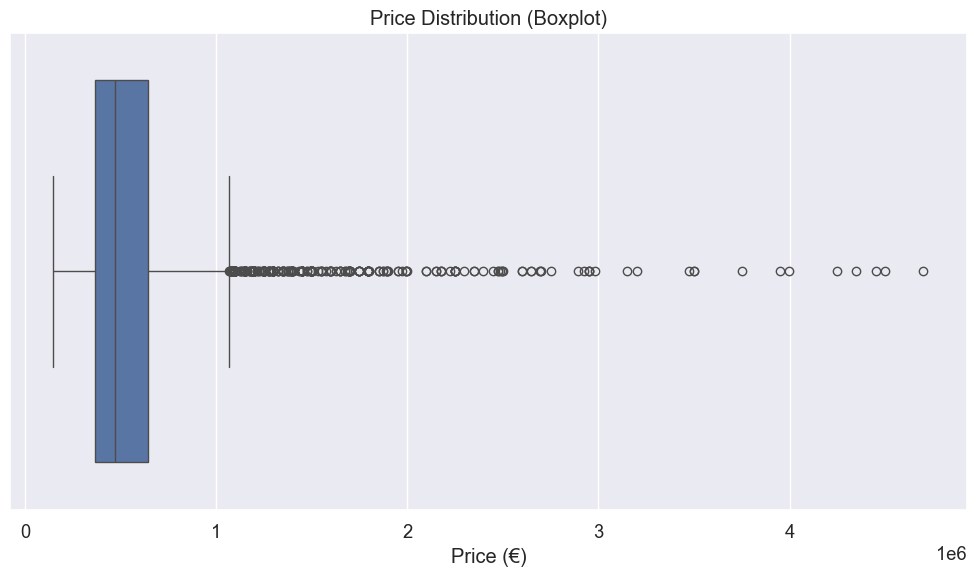

In [15]:
# Check price outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cleaned['price_cleaned'])
plt.title('Price Distribution (Boxplot)')
plt.xlabel('Price (€)')
plt.tight_layout()
plt.show()

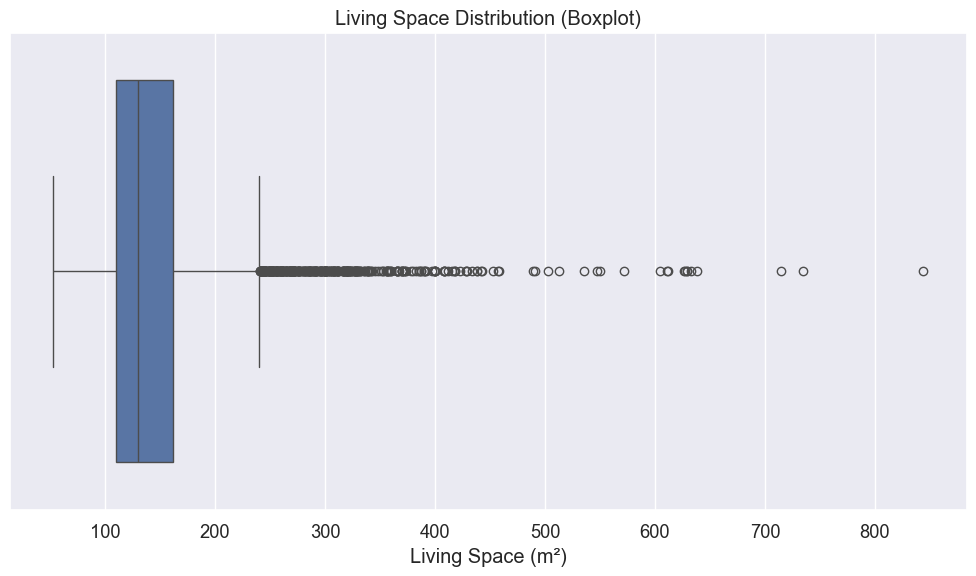

In [16]:
# Check living space outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cleaned['living_space_cleaned'])
plt.title('Living Space Distribution (Boxplot)')
plt.xlabel('Living Space (m²)')
plt.tight_layout()
plt.show()

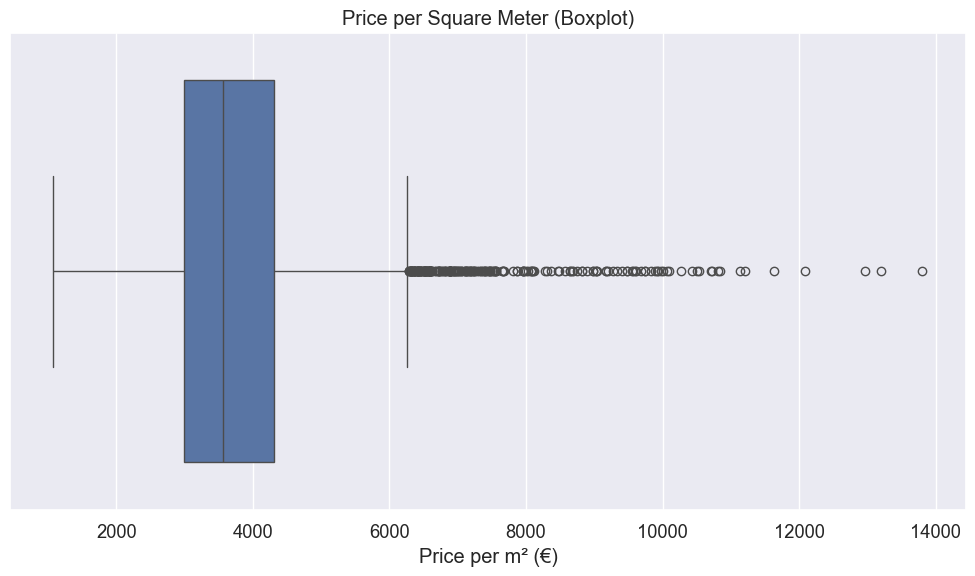

In [17]:
# Check price per sqm outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cleaned['price_per_sqm'])
plt.title('Price per Square Meter (Boxplot)')
plt.xlabel('Price per m² (€)')
plt.tight_layout()
plt.show()

In [18]:
# Basic statistics after cleaning
print("\nPrice statistics after cleaning:")
print(f"Mean: €{df_cleaned['price_cleaned'].mean():,.2f}")
print(f"Median: €{df_cleaned['price_cleaned'].median():,.2f}")
print(f"Min: €{df_cleaned['price_cleaned'].min():,.2f}")
print(f"Max: €{df_cleaned['price_cleaned'].max():,.2f}")

print("\nLiving space statistics after cleaning:")
print(f"Mean: {df_cleaned['living_space_cleaned'].mean():.2f} m²")
print(f"Median: {df_cleaned['living_space_cleaned'].median():.2f} m²")
print(f"Min: {df_cleaned['living_space_cleaned'].min():.2f} m²")
print(f"Max: {df_cleaned['living_space_cleaned'].max():.2f} m²")

print("\nPrice per square meter statistics:")
print(f"Mean: €{df_cleaned['price_per_sqm'].mean():,.2f} per m²")
print(f"Median: €{df_cleaned['price_per_sqm'].median():,.2f} per m²")
print(f"Min: €{df_cleaned['price_per_sqm'].min():,.2f} per m²")
print(f"Max: €{df_cleaned['price_per_sqm'].max():,.2f} per m²")


Price statistics after cleaning:
Mean: €558,299.40
Median: €468,500.00
Min: €149,000.00
Max: €4,700,000.00

Living space statistics after cleaning:
Mean: 146.43 m²
Median: 130.00 m²
Min: 53.00 m²
Max: 844.00 m²

Price per square meter statistics:
Mean: €3,777.53 per m²
Median: €3,561.61 per m²
Min: €1,078.27 per m²
Max: €13,807.69 per m²


In [19]:
# Identify extreme price outliers (e.g., beyond 3 standard deviations)
price_mean = df_cleaned['price_cleaned'].mean()
price_std = df_cleaned['price_cleaned'].std()
upper_limit = price_mean + 3 * price_std
lower_limit = price_mean - 3 * price_std

print(f"\nIdentifying price outliers (beyond 3 standard deviations):")
print(f"Lower limit: €{lower_limit:,.2f}")
print(f"Upper limit: €{upper_limit:,.2f}")

price_outliers = df_cleaned[(df_cleaned['price_cleaned'] > upper_limit) | 
                           (df_cleaned['price_cleaned'] < lower_limit)]
print(f"Number of price outliers: {len(price_outliers)}")


Identifying price outliers (beyond 3 standard deviations):
Lower limit: €-502,784.35
Upper limit: €1,619,383.15
Number of price outliers: 103


In [20]:
# Identify extreme price per sqm outliers
price_sqm_mean = df_cleaned['price_per_sqm'].mean()
price_sqm_std = df_cleaned['price_per_sqm'].std()
upper_sqm_limit = price_sqm_mean + 3 * price_sqm_std
lower_sqm_limit = max(0, price_sqm_mean - 3 * price_sqm_std)  # Can't be less than 0

print(f"\nIdentifying price per sqm outliers (beyond 3 standard deviations):")
print(f"Lower limit: €{lower_sqm_limit:,.2f} per m²")
print(f"Upper limit: €{upper_sqm_limit:,.2f} per m²")

price_sqm_outliers = df_cleaned[(df_cleaned['price_per_sqm'] > upper_sqm_limit) | 
                               (df_cleaned['price_per_sqm'] < lower_sqm_limit)]
print(f"Number of price per sqm outliers: {len(price_sqm_outliers)}")


Identifying price per sqm outliers (beyond 3 standard deviations):
Lower limit: €55.82 per m²
Upper limit: €7,499.23 per m²
Number of price per sqm outliers: 82


In [21]:
# For this analysis, we'll create a filtered dataset without extreme outliers

df_filtered = df_cleaned.copy()

# Remove extreme price outliers
df_filtered = df_filtered[(df_filtered['price_cleaned'] <= upper_limit) & 
                          (df_filtered['price_cleaned'] >= lower_limit)]

# Remove extreme price per sqm outliers
df_filtered = df_filtered[(df_filtered['price_per_sqm'] <= upper_sqm_limit) & 
                          (df_filtered['price_per_sqm'] >= lower_sqm_limit)]

print(f"\nRows remaining after outlier removal: {len(df_filtered)} (removed {len(df_cleaned) - len(df_filtered)} outliers)")


Rows remaining after outlier removal: 5405 (removed 150 outliers)


In [22]:
# Rename columns to be SQL-friendly (no spaces or special chars)
df_filtered = df_filtered.rename(columns={
    'Lot size (m2)': 'lot_size_m2',
    'Living space size (m2)': 'living_space_m2',
    'Build year': 'build_year',
    'Build type': 'build_type',
    'House type': 'house_type',
    'Roof': 'roof_type',
    'Rooms': 'rooms',
    'Toilet': 'toilet',
    'Floors': 'floors',
    'Energy label': 'energy_label',
    'Position': 'position',
    'Garden': 'garden',
    'Estimated neighbourhood price per m2': 'neighborhood_price_per_m2',
    'Price': 'original_price'
})

In [23]:
# Check missing values in the cleaned dataset
missing_cleaned = df_filtered.isnull().sum()
missing_cleaned_pct = (missing_cleaned / len(df_filtered)) * 100
missing_cleaned_df = pd.DataFrame({
    'Missing Values': missing_cleaned,
    'Percentage': missing_cleaned_pct
})
print("\nMissing values in cleaned dataset:")
print(missing_cleaned_df[missing_cleaned_df['Missing Values'] > 0])


Missing values in cleaned dataset:
                           Missing Values  Percentage
build_year                             99    1.831637
position                              300    5.550416
garden                                 57    1.054579
neighborhood_price_per_m2             163    3.015726
bedrooms                                8    0.148011


In [24]:
# Fill missing values for garden_type
df_filtered['garden_type'] = df_filtered['garden_type'].fillna('No Garden')

In [25]:
# Save cleaned data without outliers
df_filtered.to_csv('Documents/cleaned_housing_data.csv', index=False)

# Save full cleaned data (with outliers) for reference
df_cleaned.to_csv('Documents/full_cleaned_housing_data.csv', index=False)

print("\nSaved cleaned datasets to data/processed/")
print("1. cleaned_housing_data.csv - Main dataset for analysis (outliers removed)")
print("2. full_cleaned_housing_data.csv - Full dataset with outliers (for reference)")


Saved cleaned datasets to data/processed/
1. cleaned_housing_data.csv - Main dataset for analysis (outliers removed)
2. full_cleaned_housing_data.csv - Full dataset with outliers (for reference)


In [26]:
print("\n=== Data Cleaning Summary ===")
print(f"1. Original dataset: {df_raw.shape[0]} rows, {df_raw.shape[1]} columns")
print(f"2. Cleaned prices, sizes, and extracted features")
print(f"3. Created derived features: price_per_sqm, build_decade")
print(f"4. Removed {len(df_cleaned) - len(df_filtered)} outliers")
print(f"5. Final cleaned dataset: {df_filtered.shape[0]} rows, {df_filtered.shape[1]} columns")
print("==============================")


=== Data Cleaning Summary ===
1. Original dataset: 5555 rows, 16 columns
2. Cleaned prices, sizes, and extracted features
3. Created derived features: price_per_sqm, build_decade
4. Removed 150 outliers
5. Final cleaned dataset: 5405 rows, 24 columns
